In [79]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import jax.numpy as jnp
import jax
import jax.scipy.optimize
import matplotlib.pyplot as plt
data = pd.read_csv('creditcard.csv')

In [46]:
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [47]:
data_np = data.to_numpy()
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), unit_variance=False)
data_np[:, [0, 29]] = scaler.fit_transform(data_np[:, [0, 29]])


In [48]:

fraud_data = data_np[data_np[:, -1] == 1]
print(fraud_data.shape)

(492, 31)


In [49]:
legit_data = data_np[data_np[:, -1] == 0]
legit_data = legit_data[np.random.choice(legit_data.shape[0], 492, replace=False)]
print(legit_data.shape)

(492, 31)


In [50]:
train_dataset = np.vstack((legit_data, fraud_data))
np.random.shuffle(train_dataset)
print(legit_data.shape[0]*2)
print(train_dataset.shape)

984
(984, 31)


In [51]:
train_labels = train_dataset[:, -1]
train_dataset = train_dataset[:, :-1]
print(train_labels.shape)
print(train_dataset.shape)

(984,)
(984, 30)


In [60]:
class SVM:
    def __init__(self, lmbda=1.0):
        self.lmbda = lmbda
        self.w = None

    def loss(self, params, X, y):
        # Compute the decision function Y = Xw + b
        decision = jnp.dot(X, params[:-1]) + params[-1]
        # Compute the hinge loss
        loss_val = jnp.maximum(0, 1 - y * decision)
        # Regularization term (L2 norm of w)
        reg_term = self.lmbda * jnp.sum(params ** 2)
        # Total loss
        return reg_term + jnp.mean(loss_val)

    def train(self, X, y):
        _, n_features = X.shape

        # Initialize weights and bias
        self.w = jnp.zeros(n_features + 1)

        # Solve optimization problem
        opt_res = jax.scipy.optimize.minimize(self.loss, self.w, method="BFGS", args=(X, y))
        self.w = opt_res.x

    def predict(self, X):
        # Decision function
        decision = jnp.dot(X, self.w[:-1]) + self.w[-1]
        return jnp.sign(decision)

In [75]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(train_dataset, train_labels, test_size=0.2, random_state=42)

# Convert data to JAX arrays
data_train = jnp.array(data_train)
labels_train = jnp.array(labels_train)
data_test = jnp.array(data_test)
labels_test = jnp.array(labels_test)

print(data_train.shape)
print(labels_train.shape)
print(data_test.shape)
print(labels_test.shape)

(688, 30)
(688,)
(296, 30)
(296,)


In [76]:
svm = SVM(lmbda=0.0001)
svm.train(data_train, labels_train)

In [77]:
labels_pred_train = svm.predict(data_train)
labels_pred_test = svm.predict(data_test)

In [78]:
accuracy_train = jnp.mean(labels_pred_train == labels_train)
accuracy_test = jnp.mean(labels_pred_test == labels_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Train Accuracy: 0.4942
Test Accuracy: 0.5135


TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (30,).

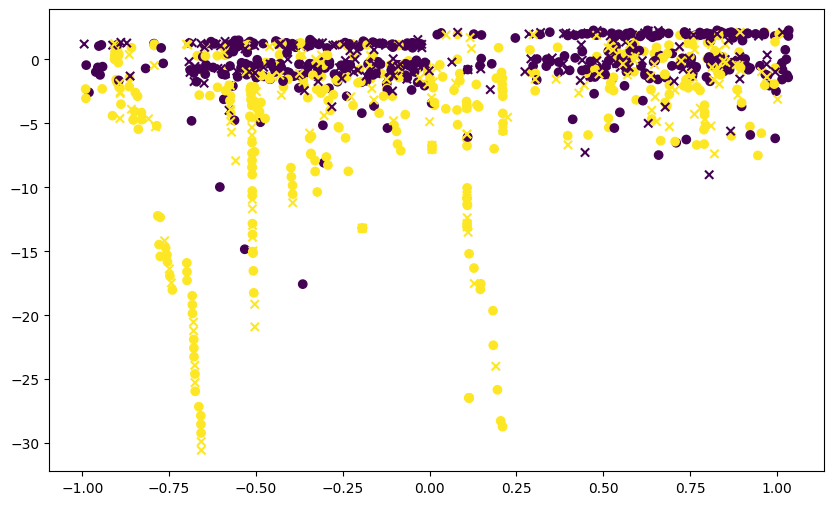

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(data_train[:, 0], data_train[:, 1], c=labels_train, label='Training data', marker='o')
plt.scatter(data_test[:, 0], data_test[:, 1], c=labels_test, label='Test data', marker='x')

# Plot the decision boundary
t = np.linspace(0, 10, 100)
xx1, xx2 = np.meshgrid(t, t)
xx = np.stack([xx1.flatten(), xx2.flatten()], axis=1)
yy = svm.predict(xx)
plt.contourf(xx1, xx2, yy.reshape(xx1.shape), alpha=0.1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('SVM Decision Boundary on Synthetic Data')
plt.legend(loc="upper right")
plt.show()